In [1]:
%matplotlib inline

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [47]:
df = pd.read_csv('oasis_longitudinal.csv') 
df = df.fillna(method = 'ffill')



In [3]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [4]:
df.tail()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323
372,OAS2_0186,OAS2_0186_MR3,Nondemented,3,1608,F,R,65,13,2.0,30.0,0.0,1333,0.801,1.317


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
Subject ID    373 non-null object
MRI ID        373 non-null object
Group         373 non-null object
Visit         373 non-null int64
MR Delay      373 non-null int64
M/F           373 non-null object
Hand          373 non-null object
Age           373 non-null int64
EDUC          373 non-null int64
SES           373 non-null float64
MMSE          373 non-null float64
CDR           373 non-null float64
eTIV          373 non-null int64
nWBV          373 non-null float64
ASF           373 non-null float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


Populating the interactive namespace from numpy and matplotlib


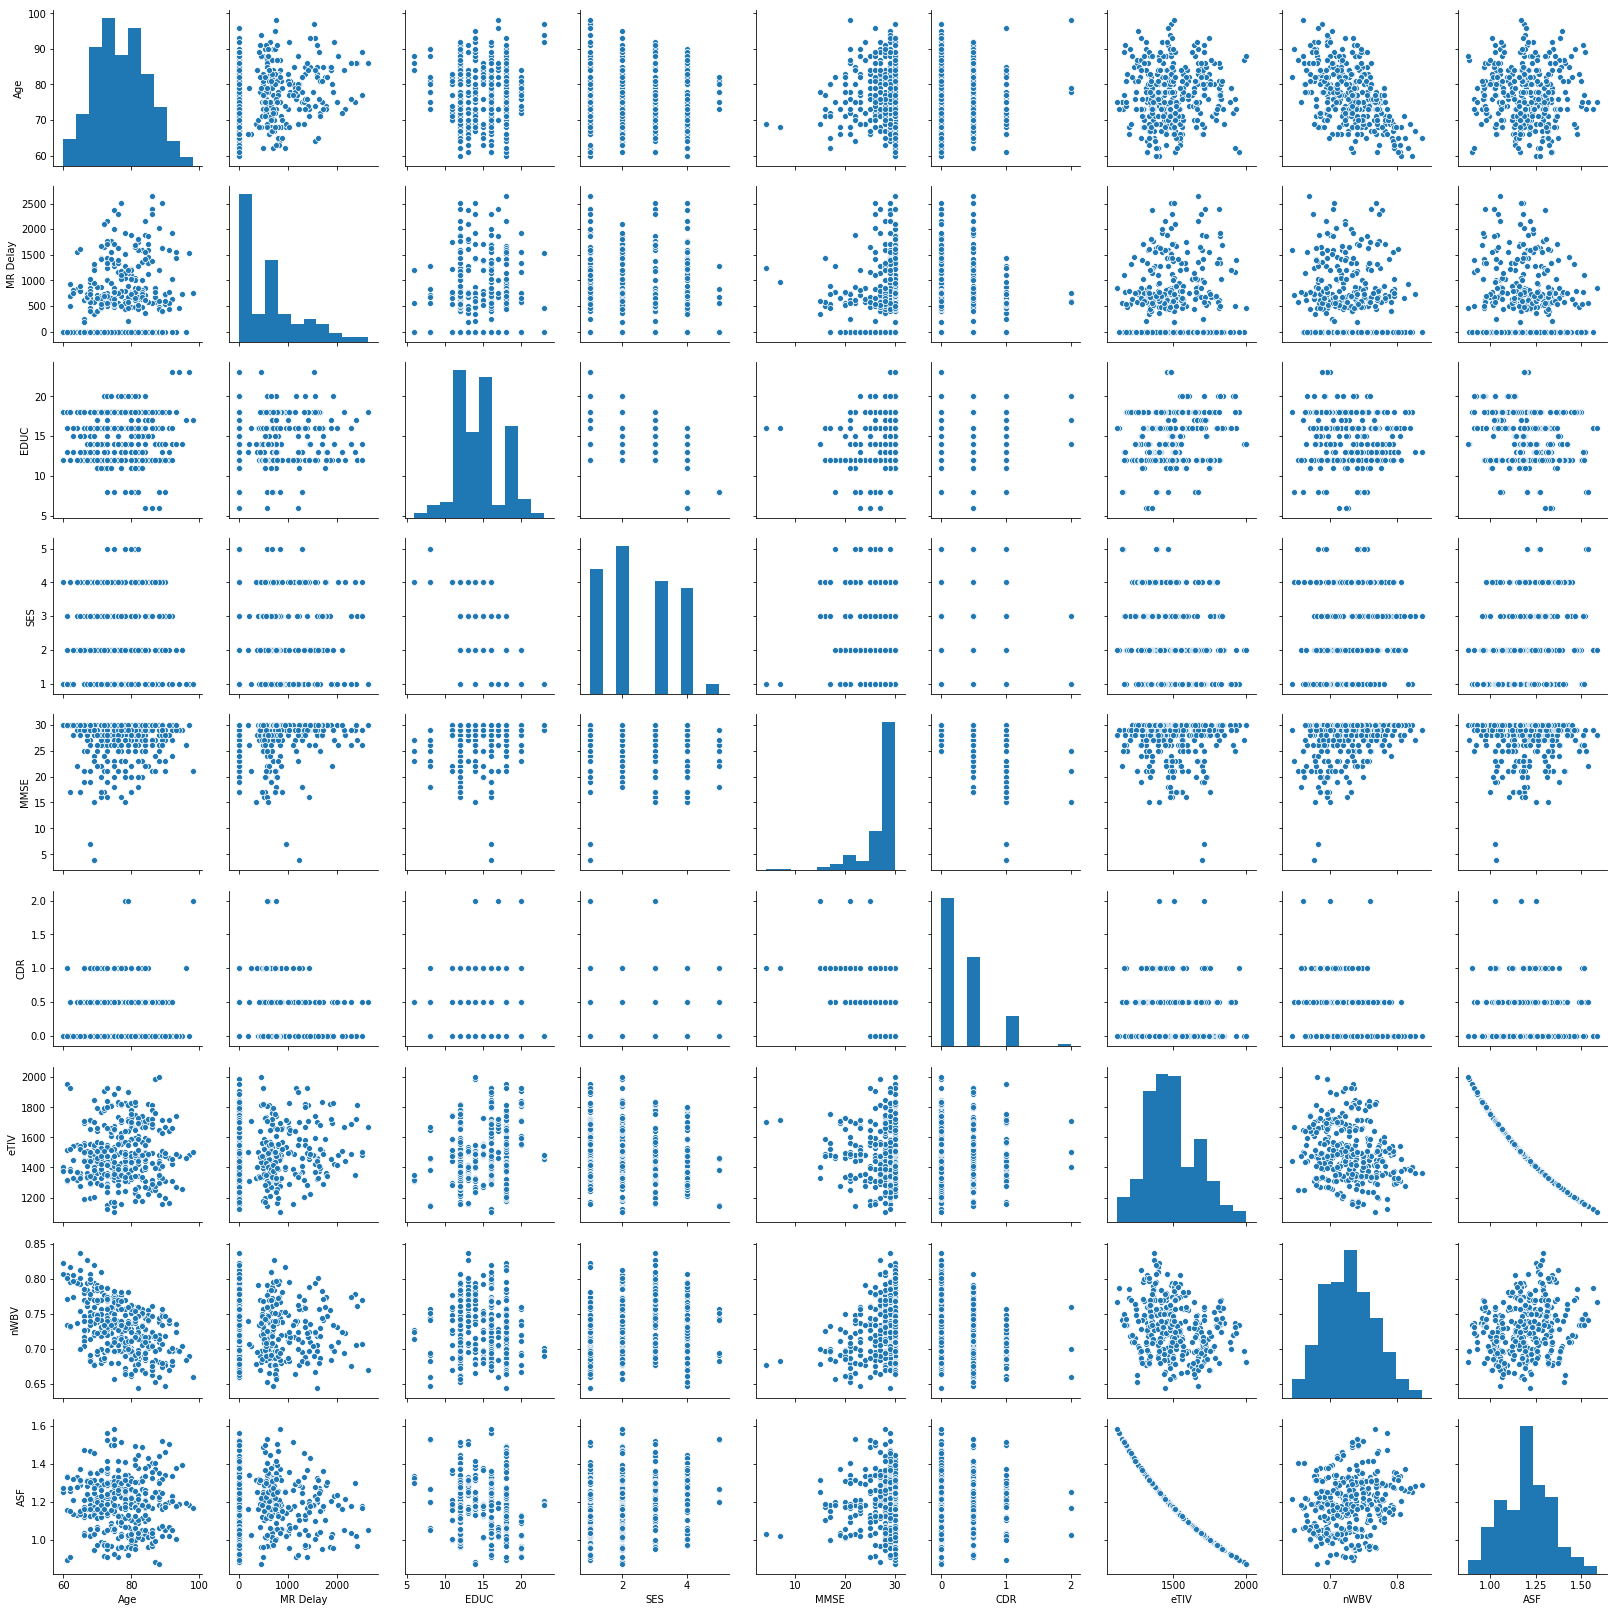

In [6]:

%pylab inline


from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

cols = ['Age', 'MR Delay', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

x = df.fillna('')

sns.pairplot(x[cols])

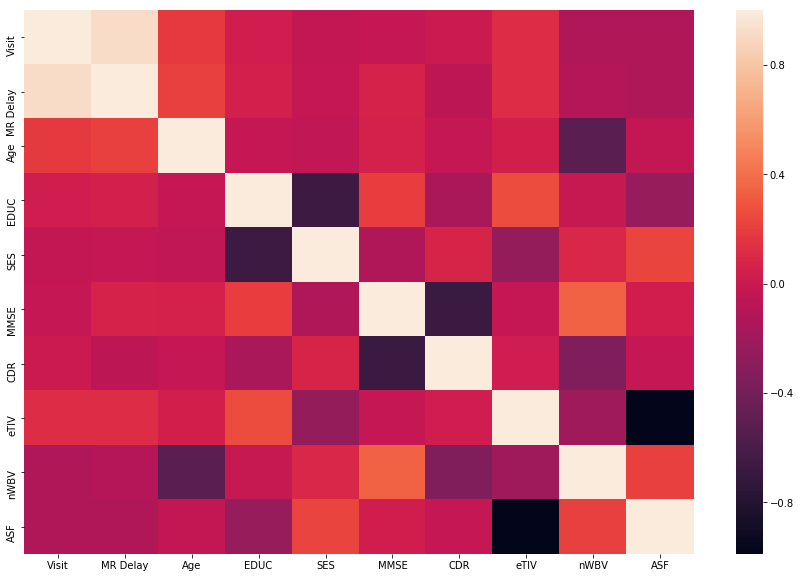

In [7]:
corr_matrix = df.corr()

rcParams['figure.figsize'] = 15, 10

sns.heatmap(corr_matrix)

In [48]:
df.drop(['MRI ID'], axis = 1, inplace = True)
df.drop(['Visit'], axis = 1, inplace = True)

In [9]:
df['CDR'].replace(to_replace = 0.0, value = 'A', inplace = True)
df['CDR'].replace(to_replace = 0.5, value = 'B', inplace = True)
df['CDR'].replace(to_replace = 1.0, value = 'C', inplace = True)
df['CDR'].replace(to_replace = 2.0, value = 'D', inplace = True)

df.head()

,Subject ID,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,0,M,R,87,14,2.0,27.0,A,1987,0.696,0.883
1,OAS2_0001,Nondemented,457,M,R,88,14,2.0,30.0,A,2004,0.681,0.876
2,OAS2_0002,Demented,0,M,R,75,12,2.0,23.0,B,1678,0.736,1.046
3,OAS2_0002,Demented,560,M,R,76,12,2.0,28.0,B,1738,0.713,1.010
4,OAS2_0002,Demented,1895,M,R,80,12,2.0,22.0,B,1698,0.701,1.034


In [10]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

for x in df.columns:
    f = LabelEncoder()
    df[x] = f.fit_transform(df[x])

In [11]:
df.head()

,Subject ID,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,2,0,1,0,27,5,1,14,0,284,35,1
1,0,2,15,1,0,28,5,1,17,0,285,20,0
2,1,1,0,1,0,15,3,1,10,1,231,73,52
3,1,1,32,1,0,16,3,1,15,1,254,51,32
4,1,1,185,1,0,20,3,1,9,1,238,40,46


In [49]:
train, test = train_test_split(df, test_size = 0.3)

In [50]:
X_train = train[['M/F', 'Age', 'EDUC', 'SES',  'eTIV', 'ASF']]
y_train = train.CDR

X_test = test[['M/F', 'Age', 'EDUC', 'SES',  'eTIV',  'ASF']]
y_test = test.CDR

In [14]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

E:\project\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\project\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
E:\project\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [15]:

y_train = np.ravel(y_train)
X_train = np.asarray(X_train)

y_test = np.ravel(y_test)
X_test = np.asarray(X_test)

# LOGISTIC REGRESSION

In [16]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

classifier.fit(X_train, y_train)

prediction = classifier.predict(X_test)

E:\project\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\project\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [17]:
classifier.score(X_test, y_test)

0.6160714285714286

In [18]:
classifier.score(X_train, y_train)

0.632183908045977

# DECISION TREE

In [19]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth = 12)

classifier.fit(X_train, y_train)

classifier.predict(X_test)

array([0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       2, 1, 0, 2, 0, 2, 0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1,
       1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1,
       0, 0])

In [20]:
classifier.score(X_train, y_train)

0.9808429118773946

In [21]:
classifier.score(X_test, y_test)

0.5714285714285714

# KNN MODEL

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Avec n_neighbors tu peux spécifier le nombre de voisins à regarder.

knn = KNeighborsClassifier(n_neighbors = 2)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [23]:
knn.score(X_train, y_train)

0.8160919540229885

In [24]:
knn.predict(X_test)

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

In [25]:
knn.score(X_test, y_test)

0.6339285714285714


# svc model

In [26]:
from sklearn.svm import SVC

svc = SVC(kernel = "linear", C = 0.01)

svc.fit(X_train, y_train)

prediction = svc.predict(X_test)

In [27]:
svc.score(X_train, y_train)

0.5555555555555556

In [28]:
svc.score(X_test, y_test)

0.5446428571428571

In [29]:
df.head()

,Subject ID,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,2,0,1,0,27,5,1,14,0,284,35,1
1,0,2,15,1,0,28,5,1,17,0,285,20,0
2,1,1,0,1,0,15,3,1,10,1,231,73,52
3,1,1,32,1,0,16,3,1,15,1,254,51,32
4,1,1,185,1,0,20,3,1,9,1,238,40,46


In [30]:

df['Group'].replace(to_replace = 2, value = 0, inplace = True)

df['Group'].replace(to_replace = 1, value = 1, inplace = True)

df.head()

,Subject ID,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,0,1,0,27,5,1,14,0,284,35,1
1,0,0,15,1,0,28,5,1,17,0,285,20,0
2,1,1,0,1,0,15,3,1,10,1,231,73,52
3,1,1,32,1,0,16,3,1,15,1,254,51,32
4,1,1,185,1,0,20,3,1,9,1,238,40,46


In [31]:
train, test = train_test_split(df, test_size = 0.3)

In [32]:

X_train = train[['M/F', 'Age', 'EDUC', 'SES',  'eTIV', 'ASF']]
y_train = train.Group

X_test = test[['M/F', 'Age', 'EDUC', 'SES',  'eTIV',  'ASF']]
y_test = test.Group

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

E:\project\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\project\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  """
E:\project\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  import sys


In [43]:
y_train = np.ravel(y_train)
X_train = np.asarray(X_train)

y_test = np.ravel(y_test)
X_test = np.asarray(X_test)

# DecisionTrees After Standardization

In [44]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth = 20)

classifier.fit(X_train, y_train)

classifier.predict(X_test)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1])

In [45]:
classifier.score(X_train, y_train)

1.0

In [46]:
classifier.score(X_test, y_test)

0.8571428571428571